In [1]:
import os
import time
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.model_selection import KFold

from skreg import util, priors

kernel_dir = '../data/kernel_dataset' # where saved kernels from the phase 1 trials are located
gaussian_dir = '../data/gaussian_fit' # where fitted Gaussians will be saved

if not os.path.isdir(gaussian_dir):
    os.mkdir(gaussian_dir)

Using TensorFlow backend.


## 1) Load resulting filters from the 20 CNN trials

In [2]:
def center(W):
    W_shape = W.shape
    # convert to float64 for accuracy
    W = W.astype(np.float64)
    # flatten
    W = np.reshape(W, (W_shape[0],-1))
    W = W - W.mean(axis=0)
    # back to original shape
    W = np.reshape(W, W_shape)
    # convert back to float32
    W = W.astype(np.float32)
    
    return W

def group(D):
    n,k,k,c = D.shape
    # (n,k,k,c) -> (c,n,k,k) -> (c*n,k,k)
    D = np.transpose(D, axes=[3,0,1,2])
    D = np.reshape(D, (n*c,k,k))
    
    return D

def get_weights(layer_ix, n=20, group_channels=False):
    D = []
    for i in range(n):
        model_file = os.path.join(kernel_dir, 'trial%0.3i/cnn.h5'%i)
        lname = 'conv2d_%i'%layer_ix
        with h5py.File(model_file, 'r') as f:
            # W is shape (k,k,c,m)
            W = f[lname][lname]['kernel:0'].value
        k,_,c,m = W.shape
        # (k,k,c,m) -> (m,k,k,c)
        W = np.transpose(W, axes=[3,0,1,2])
        D.append(W)
    D = np.concatenate(D) # create (n*m,k,k,c)
    if group_channels:
        D = group(D)
    # subtract the mean
    D = center(D)

    return D

In [4]:
D1 = get_weights(layer_ix=1, group_channels=False)
D2 = get_weights(layer_ix=2, group_channels=True)
D3 = get_weights(layer_ix=3, group_channels=True)

# Fit Gaussians

In [5]:
def test_fit(D, mode, cv=3, seed=43):
    kf = KFold(cv, shuffle=True, random_state=seed)
    scores = np.zeros(cv)
    for i, (ix_train, ix_test) in enumerate(kf.split(D)):
        if mode == 'ig':
            # i.i.d. gaussian
            prior = priors.IndependentGaussian(data_shape=D.shape[1:])
        elif mode == 'cg':
            # correlated gaussian
            prior = priors.CorrelatedGaussian(data_shape=D.shape[1:])
        else:
            raise Exception
        prior.fit(D[ix_train])
        scores[i] = np.mean(prior.score(D[ix_test]))
    
    return scores.mean()

def fit_correlated_gaussian(D, group_channels=False, vlim='infer'):
    # fit gaussian
    prior = priors.CorrelatedGaussian(data_shape=D.shape[1:])
    prior.fit(D)
    # show samples
    samples = prior.sample(20)
    if group_channels:
        np.random.seed(3)
        ix = np.random.choice(range(D.shape[0]), 20, replace=False)
        D = D[ix]
    else:
        D = D[:20]
    print('some kernels from the dataset:')
    util.view_kernel_samples(D, vlim=vlim, gray=group_channels)
    plt.show()
    print('some samples from the fitted Gaussian:')
    util.view_kernel_samples(samples, vlim=vlim, gray=group_channels)
    plt.show()
    # show covariance matrix
    util.view_covariance(prior.Cov)
    plt.show()
    
    return prior

# Conv1

In [6]:
print('mean log-like for i.i.d. Gaussian: %0.2f' % test_fit(D1, mode='ig'))
print('mean log-like for correlated Gaussian: %0.2f' % test_fit(D1, mode='cg'))

mean log-like for i.i.d. Gaussian: 144.11
mean log-like for correlated Gaussian: 358.46


some kernels from the dataset:


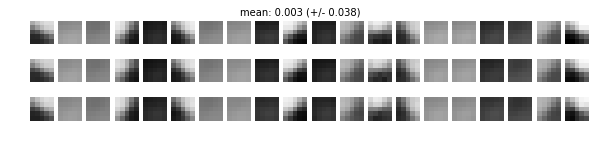

some samples from the fitted Gaussian:


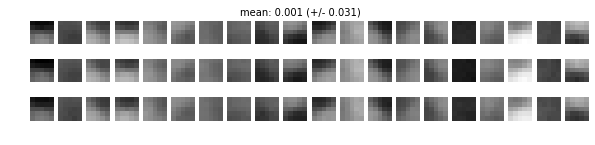

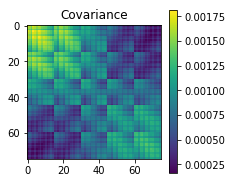

In [7]:
prior1 = fit_correlated_gaussian(D1, group_channels=False)

In [8]:
np.save(
    os.path.join(gaussian_dir,'conv1_cov_rank3.npy'), 
    prior1.Cov.astype(np.float32)
)

# Conv2

In [9]:
print('mean log-like for i.i.d. Gaussian: %0.2f' % (5.*test_fit(D2, mode='ig')))
print('mean log-like for correlated Gaussian: %0.2f' % (5.*test_fit(D2, mode='cg')))

mean log-like for i.i.d. Gaussian: 289.35
mean log-like for correlated Gaussian: 413.26


some kernels from the dataset:


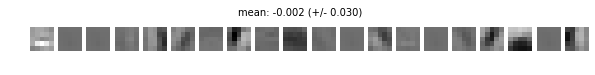

some samples from the fitted Gaussian:


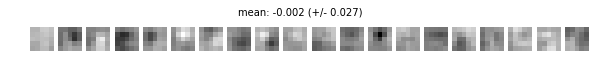

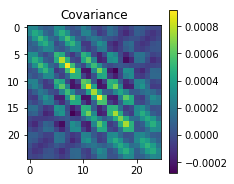

In [10]:
prior2 = fit_correlated_gaussian(D2, group_channels=True)

In [11]:
np.save(
    os.path.join(gaussian_dir,'conv2_cov_rank2.npy'), 
    prior2.Cov.astype(np.float32)
)

# Conv3

In [12]:
print('mean log-like for i.i.d. Gaussian: %0.2f' % (10.*test_fit(D3, mode='ig')))
print('mean log-like for correlated Gaussian: %0.2f' % (10.*test_fit(D3, mode='cg')))

mean log-like for i.i.d. Gaussian: 621.47
mean log-like for correlated Gaussian: 828.05


some kernels from the dataset:


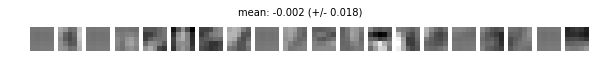

some samples from the fitted Gaussian:


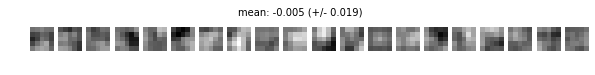

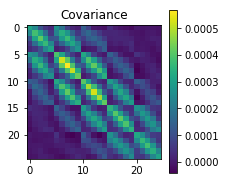

In [13]:
prior3 = fit_correlated_gaussian(D3, group_channels=True)

In [14]:
np.save(
    os.path.join(gaussian_dir,'conv3_cov_rank2.npy'), 
    prior3.Cov.astype(np.float32)
)